## Random Forest Classifier
------

In [1]:
from Modules   import *
from Functions import *

Reading, cleaning and splitting the data

In [2]:
df = pd.read_csv('../data/breastcancer.csv')
print(f"The shape of the Dataframe is {df.shape}\n {'-- '*50} ")
# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
df = df.astype({'class' : 'category', 'id' : 'category'})             # chaning type to category
df.drop_duplicates(keep = 'first', inplace = True)                    # removing dublicates
df.dropna(how = 'any', inplace = True)                                # dropping NaNs
df.head()

The shape of the Dataframe is (629, 11)
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --  


,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1246562,10,2,2,1,2,6.0,1,1,2,1
1,822829,7,6,4,8,10,10.0,9,5,3,1
2,1217264,1,1,1,1,2,1.0,3,1,1,0
3,1296025,4,1,2,1,2,1.0,1,1,1,0
4,1203096,1,1,1,1,1,1.0,3,1,1,0


In [140]:
df_features = df.drop(['id', 'class'], axis = 1)
df_target   = df['class']

X_train, X_test, y_train, y_test = train_test_split(df_features,                    
                                                    df_target,
                                                    test_size    = 0.25,
                                                    shuffle      = True,
                                                    random_state = 100
                                                    )
print(f"The shapes of the X_train, and y_train are {X_train.shape, y_train.shape} respectively\n {'-- '*25}")
print(f"The shapes of the X_test, and y_test are   {X_test.shape, y_test.shape} respectively\n {'-- '*25}")

The shapes of the X_train, and y_train are ((456, 9), (456,)) respectively
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
The shapes of the X_test, and y_test are   ((152, 9), (152,)) respectively
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [177]:

search_space_grid = {
                    'RFC__n_estimators'     : [24,25,26],  
                    'RFC__max_depth'        : [1,2,3,4,5],  
                    'RFC__min_samples_leaf' : [2,3,4,5,6],     
                    'RFC__min_samples_split': [2,3,4,5], 
                    }
# -------------------------------------------------------------

pipeline_rfc_pca = Pipeline([
                            #('poly', PolynomialFeatures(degree = 2, include_bias = False)),
                             ('std' , StandardScaler()), 
                             #('pca' , PCA(n_components = 2, random_state = 100)),
                             ('RFC' , RandomForestClassifier(class_weight = 'balanced',
                                                             random_state = 100)) 
                            ])

GridSearch_RFC = GridSearchCV(estimator  = pipeline_rfc_pca, 
                              param_grid = search_space_grid, 
                              scoring    = 'f1',
                              cv         = 2,
                              n_jobs     = -1
                              )

In [178]:
GridSearch_RFC.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('RFC',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=100))]),
             n_jobs=-1,
             param_grid={'RFC__max_depth': [1, 2, 3, 4, 5],
                         'RFC__min_samples_leaf': [2, 3, 4, 5, 6],
                         'RFC__min_samples_split': [2, 3, 4, 5],
                         'RFC__n_estimators': [24, 25, 26]},
             scoring='f1')

RFC Grid best estimator: Pipeline(steps=[('std', StandardScaler()),
                ('RFC',
                 RandomForestClassifier(class_weight='balanced', max_depth=4,
                                        min_samples_leaf=2, n_estimators=25,
                                        random_state=100))])
RFC Grid best paramters: {'RFC__max_depth': 4, 'RFC__min_samples_leaf': 2, 'RFC__min_samples_split': 2, 'RFC__n_estimators': 25}
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Scoring of GridSearch PCA-RFC
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Model,F1 Score,Recall,Precision,Accuracy
GridSearch PCA-RFC,0.969231,1.000000,0.940299,0.973684


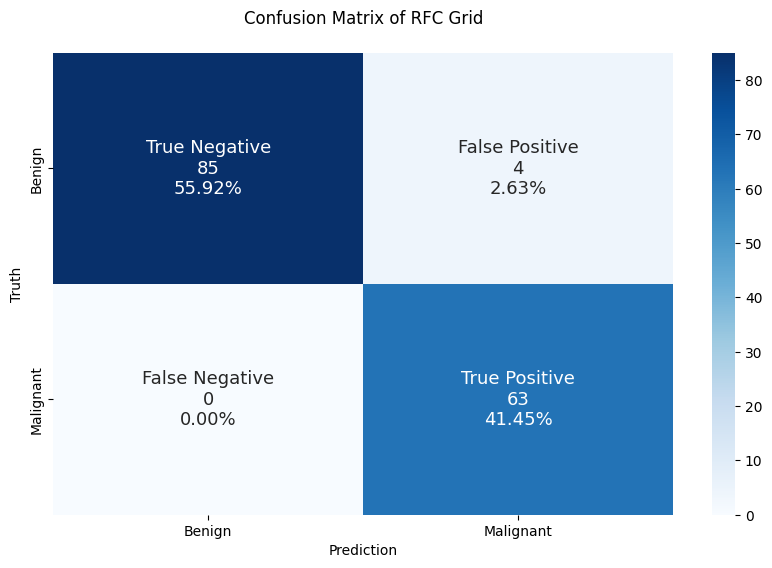

In [179]:
print('RFC Grid best estimator:', GridSearch_RFC.best_estimator_)
print('RFC Grid best paramters:', GridSearch_RFC.best_params_)
print('-- '*25)
print('Scoring of GridSearch PCA-RFC')



y_pred_RFC    = GridSearch_RFC.predict(X_test)
f1_RFC        = f1_score(y_test, y_pred_RFC)
recall_RFC    = recall_score(y_test, y_pred_RFC)
precision_RFC = precision_score(y_test, y_pred_RFC)
accuracy_RFC  = accuracy_score(y_test, y_pred_RFC)


grid_RFC_metrics  = pd.DataFrame({
                                  'Model'    : ['GridSearch PCA-RFC'],
                                  'F1 Score' : [f1_RFC],
                                  'Recall'   : [recall_RFC],
                                  'Precision': [precision_RFC],
                                  'Accuracy' : [accuracy_RFC]
                                })
print('-- '*25)
display(grid_RFC_metrics.style.hide())
Confusion_Matrix_Func(y_test, y_pred_RFC, 'RFC Grid');

-------------

### Plotting a tree and Features Importance

In [182]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = RandomForestClassifier(class_weight      = 'balanced',
                               n_estimators      = 25,
                               max_depth         = 4, 
                               random_state      = 100,
                               min_samples_leaf  = 2,
                               min_samples_split = 2)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=2,
                       n_estimators=25, random_state=100)

Plotting the first tree in the Random forest 

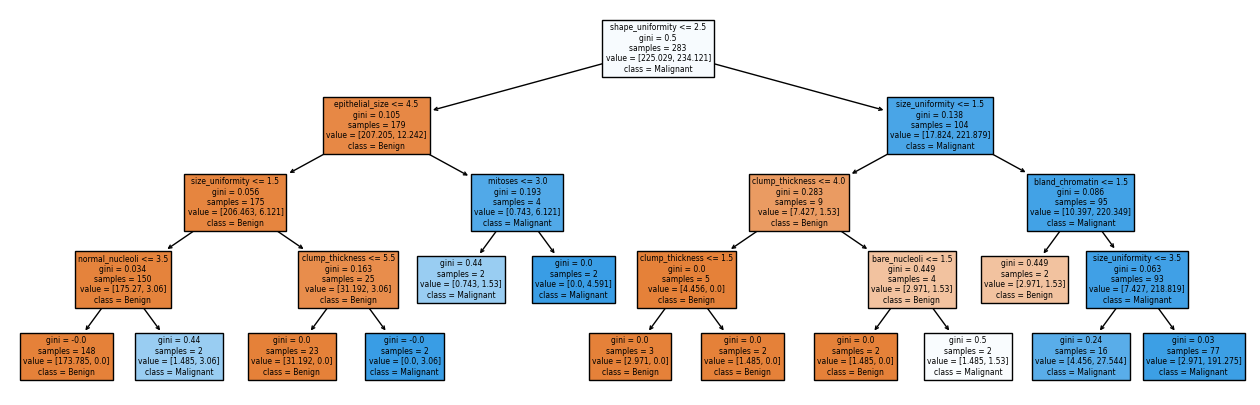

In [185]:

plt.figure(figsize = (16, 5)) 
tree_to_visualize  = model.estimators_[0]
# -----------------------------------------------
plot_tree(decision_tree = tree_to_visualize, 
          feature_names = X_train.columns,
          class_names   = ['Benign','Malignant'],
          filled        =  True );

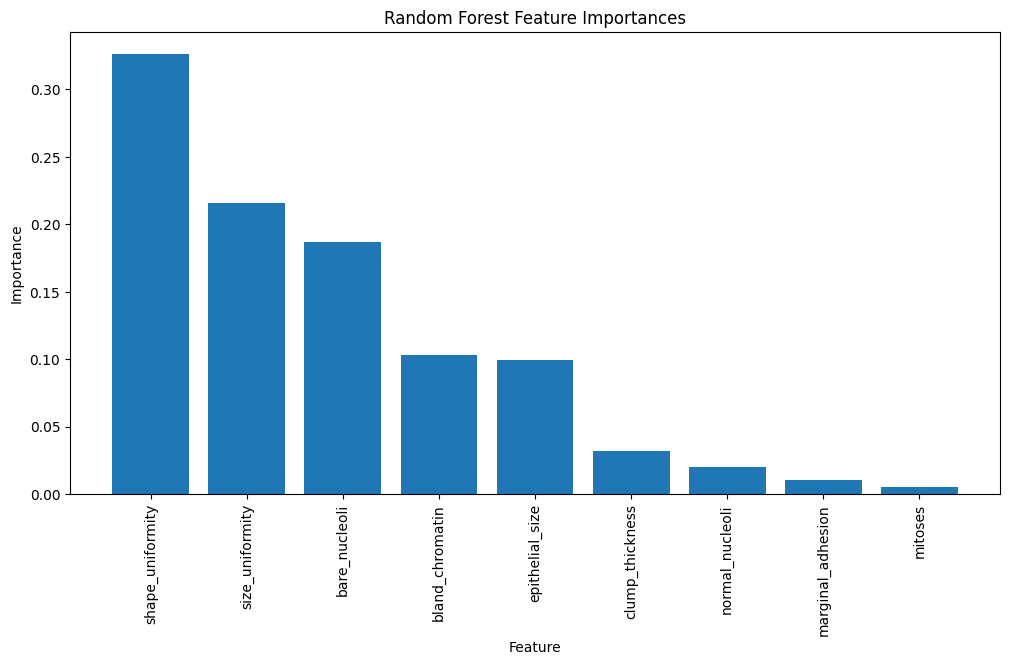

In [195]:

model = RandomForestClassifier(class_weight='balanced',
                               n_estimators=25,
                               max_depth=4,
                               random_state=100,
                               min_samples_leaf=2,
                               min_samples_split=2)

model.fit(X_train, y_train)

# Get feature importances from the trained random forest
feature_importances = model.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Sort feature importances in descending order
indices = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()


[]

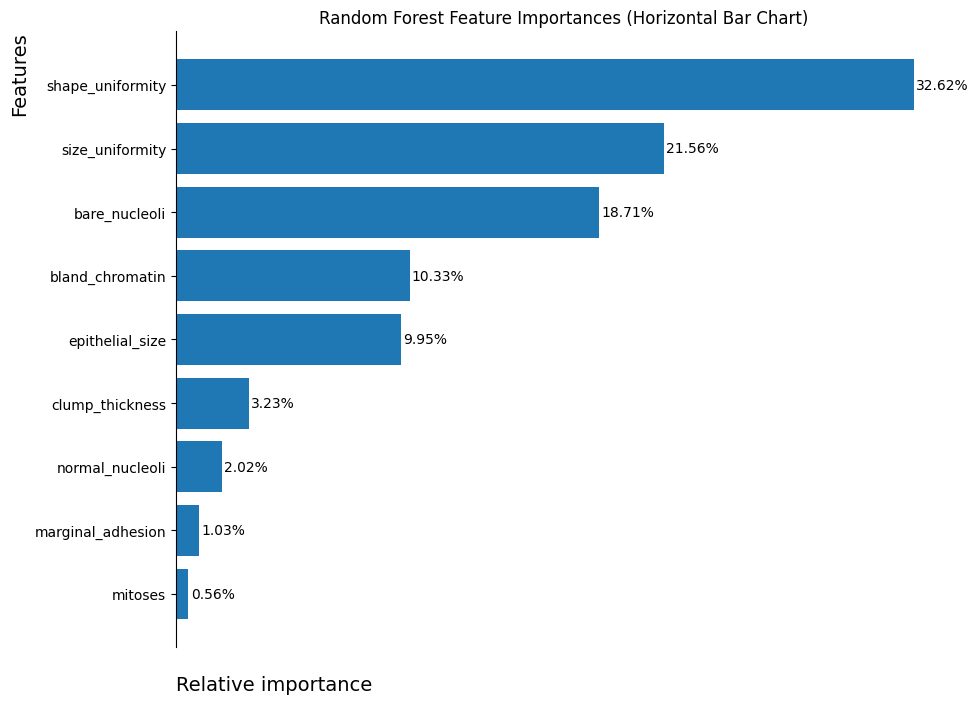

In [209]:
fig, ax = plt.subplots(figsize=(10, 8))

# Feature importances from the trained random forest
feature_importances = model.feature_importances_

# Names of features
feature_names = X_train.columns

# Sort feature importances in descending order
indices = feature_importances.argsort()
bars    = ax.barh(range(X_train.shape[1]), feature_importances[indices], align="center")

plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances (Horizontal Bar Chart)")

#--------------------Formatting the Chart ------------------------------
ax.set_xlabel('\nRelative importance',
              size                = 14,
              position            = [0, 0],
              horizontalalignment = 'left')
ax.set_ylabel('Features',
              size                = 14,
              position            = [0, 1],
              horizontalalignment = 'right')
ax.spines[['top', 'right']].set_visible(False)

# Add labels on each bar
for bar, value in zip(bars, feature_importances[indices]):
    ax.text(
        x     = bar.get_width() + 0.001,             # x-coordinate of the text
        y     = bar.get_y() + bar.get_height() / 2,  # y-coordinate of the text
        s     = f'{value:.2%}',                      # Text to be displayed
        ha    = 'left',                              # Horizontal alignment
        va    = 'center',                            # Vertical alignment
        size  = 10,
        color = 'black'
    )

ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([])